In [1]:
DATASET = "/content/drive/MyDrive/ml_isofh/data/brain_tumor_2_8"
saved_model_dir = "/content/drive/MyDrive/saved_model"

In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

In [4]:


IMG_SIZE = (160, 160)
IMG_SHAPE = (160, 160, 3)
MEAN = [0.23740229, 0.23729787, 0.23700129]
STD = [0.23173477, 0.23151317, 0.23122775]

preprocess_input = keras.applications.mobilenet_v2.preprocess_input

inputs = keras.Input(shape=IMG_SIZE)
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False
)

base_model.trainable = False
global_average_layer = keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(1)

class ImagePreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
      super(ImagePreprocessLayer, self).__init__()
    def call(self, img):
      print(img)
      img = tf.convert_to_tensor(img)
      gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
      gray = cv2.GaussianBlur(gray, (5, 5), 0)
      # threshold the image, then perform a series of erosions +
      # dilations to remove any small regions of noise
      thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
      thresh = cv2.erode(thresh, None, iterations=2)
      thresh = cv2.dilate(thresh, None, iterations=2)
      # find contours in thresholded image, then grab the largest one
      cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
      cnts = imutils.grab_contours(cnts)
      c = max(cnts, key=cv2.contourArea)
      # find the extreme points
      extLeft = tuple(c[c[:, :, 0].argmin()][0])
      extRight = tuple(c[c[:, :, 0].argmax()][0])
      extTop = tuple(c[c[:, :, 1].argmin()][0])
      extBot = tuple(c[c[:, :, 1].argmax()][0])
      ADD_PIXELS = 0
      new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
      return tf.convert_to_tensor(new_img)


def img_enhanced(img):
  print(type(img))
  img = img.numpy()
  print(img, "OK")

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (5, 5), 0)
  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)
  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)
  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = add_pixels_value
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
  return new_img

inputs = keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = keras.layers.Normalization(mean=MEAN, variance=STD)(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = keras.Model(inputs, outputs)


class Model(tf.Module):
    def __init__(self):
      self.model = model
      self.model.compile(optimizer=tf.keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(from_logits=True))

    @tf.function(input_signature=[
        tf.TensorSpec([None, 160, 160, 3], tf.float32),
        tf.TensorSpec([None, ], tf.float32),
    ])
    def train(self, x, y):
      with tf.GradientTape() as tape:
          pred = self.model(x)
          loss = self.model.loss(y, pred)
      gradients = tape.gradient(loss, self.model.trainable_variables)
      self.model.optimizer.apply_gradients(
          zip(gradients, self.model.trainable_variables))
      result = {"loss": loss}
      return result

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def save(self, checkpoint_path):
      tensor_names = [weight.name for weight in self.model.weights]
      tensors_to_save = [weight.read_value() for weight in self.model.weights]
      tf.raw_ops.Save(
          filename=checkpoint_path, tensor_names=tensor_names,
          data=tensors_to_save, name='save')
      return {
          "checkpoint_path": checkpoint_path
      }

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def restore(self, checkpoint_path):
      restored_tensors = {}
      for var in self.model.weights:
          restored = tf.raw_ops.Restore(
              file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
              name='restore')
          var.assign(restored)
          restored_tensors[var.name] = restored
      return restored_tensors

    @tf.function(input_signature=[
      tf.TensorSpec(shape=[], dtype=tf.string)
    ])
    def get_trainable_weights(self,str="OK"):
      trainable_weights = [weight.read_value() for weight in self.model.trainable_weights]
      return {
          "weights": trainable_weights[0],
          "bias": trainable_weights[1]
      }

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[1280, 1], dtype=tf.float32),
        tf.TensorSpec(shape=[1,], dtype=tf.float32)
    ])
    def update_weights(self, w, b):
      current_weight = self.model.trainable_variables;
      new_weights = [w, b]
      for current_val, new_val in zip(current_weight, new_weights):
          current_val.assign(tf.convert_to_tensor(new_val, dtype=current_val.dtype))
      return {
          "message": "Weights updated successfully."
      }



    @tf.function(input_signature=[
        tf.TensorSpec([None, 160, 160, 3], tf.float32)
    ])
    def infer(self, x):
      logits = self.model(x)
      probabilities = tf.nn.sigmoid(x)
      return {
          "output": probabilities,
          "logits": logits
      }

    @tf.function(input_signature=[
      tf.TensorSpec(shape=[], dtype=tf.string)
    ])
    def summary(self, str="OK"):
      return self.model.summary()


In [5]:
classes = ["NO", "YES"]

In [6]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True

)
test_gen = ImageDataGenerator(
    rescale=1./255
)

train_batches = train_gen.flow_from_directory(
    DATASET + "/TRAIN",
    target_size=(160, 160),
    class_mode='binary',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=classes
)

test_batches = test_gen.flow_from_directory(
    DATASET + "/TEST",
    target_size=(160, 160),
    class_mode='binary',
    batch_size=4,
    shuffle=False,
    color_mode="rgb",
    classes=classes
)

Found 202 images belonging to 2 classes.
Found 51 images belonging to 2 classes.


In [ ]:
len(train_batches)

51

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 normalization (Normalizatio  (None, 160, 160, 3)      0         
 n)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                      

In [7]:
NUM_EPOCHS = 100
step_per_epochs = len(train_batches)
epochs = np.arange(1, NUM_EPOCHS + 1, 1)
losses = np.zeros([NUM_EPOCHS])
m = Model()

# for i in range(NUM_EPOCHS):
#   print(f"Training epoch {i + 1}/{NUM_EPOCHS}")
#   for step, (x,y) in enumerate(train_batches):
#     if (step+1) == step_per_epochs:
#       break
#     result = m.train(x, y)
#     trainable_weights = m.get_trainable_weights()
#     trainable_weights = [weight.numpy() for weight in trainable_weights]

#     msg = m.update_weights(trainable_weights[0], trainable_weights[1])
#   losses[i] = result['loss']
#   if (i + 1) % 10 == 0:
#     print(f"Finished {i+1} epochs")
#     print(f"  loss: {losses[i]:.3f}")

# # Save the trained weights to a checkpoint.
# m.save('/tmp/model.ckpt')

In [9]:
m.get_trainable_weights()

{'weights': <tf.Tensor: shape=(1280, 1), dtype=float32, numpy=
 array([[-0.01070463],
        [-0.03723282],
        [ 0.00034458],
        ...,
        [-0.0408719 ],
        [ 0.03487955],
        [ 0.06027184]], dtype=float32)>,
 'bias': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>}

In [ ]:
!pip install tf-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.0/492.0 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.9/440.9 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.1 MB/s eta 0:00:00


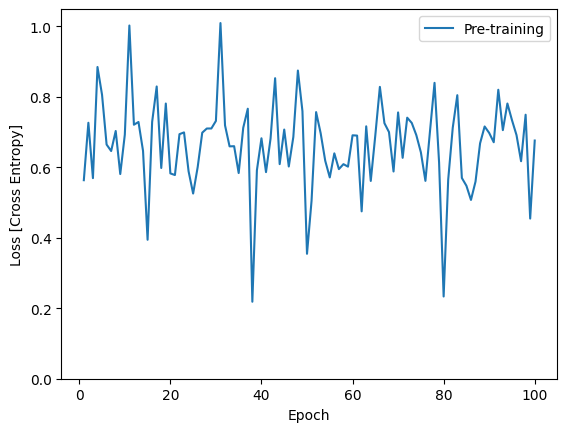

In [ ]:
plt.plot(epochs, losses, label='Pre-training')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cross Entropy]')
plt.legend();

In [ ]:
SAVED_MODEL_DIR = saved_model_dir

tf.saved_model.save(
    m,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            m.train.get_concrete_function(),
        '0_infer':
            m.infer.get_concrete_function(),
        'save':
            m.save.get_concrete_function(),
        'restore':
            m.restore.get_concrete_function(),
        "get_trainable_weights":
            m.get_trainable_weights.get_concrete_function(),
        "update_weights":
            m.update_weights.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 normalization (Normalizatio  (None, 160, 160, 3)      0         
 n)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                      

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

infer = interpreter.get_signature_runner("infer")

In [ ]:
interpreter.get_signature_list()

{'get_trainable_weights': {'inputs': ['str'],
  'outputs': ['output_0', 'output_1']},
 'infer': {'inputs': ['x'], 'outputs': ['logits', 'output']},
 'restore': {'inputs': ['checkpoint_path'],
  'outputs': ['Conv1/kernel:0',
   'Conv_1/kernel:0',
   'Conv_1_bn/beta:0',
   'Conv_1_bn/gamma:0',
   'Conv_1_bn/moving_mean:0',
   'Conv_1_bn/moving_variance:0',
   'block_10_depthwise/depthwise_kernel:0',
   'block_10_depthwise_BN/beta:0',
   'block_10_depthwise_BN/gamma:0',
   'block_10_depthwise_BN/moving_mean:0',
   'block_10_depthwise_BN/moving_variance:0',
   'block_10_expand/kernel:0',
   'block_10_expand_BN/beta:0',
   'block_10_expand_BN/gamma:0',
   'block_10_expand_BN/moving_mean:0',
   'block_10_expand_BN/moving_variance:0',
   'block_10_project/kernel:0',
   'block_10_project_BN/beta:0',
   'block_10_project_BN/gamma:0',
   'block_10_project_BN/moving_mean:0',
   'block_10_project_BN/moving_variance:0',
   'block_11_depthwise/depthwise_kernel:0',
   'block_11_depthwise_BN/beta:0',


In [ ]:

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("input details", input_details)
print("ouput details", output_details)

input details [{'name': 'get_trainable_weights_str:0', 'index': 0, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.bytes_'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
ouput details [{'name': 'StatefulPartitionedCall:1', 'index': 3, 'shape': array([1], dtype=int32), 'shape_signature': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'StatefulPartitionedCall:0', 'index': 4, 'shape': array([1280,    1], dtype=int32), 'shape_signature': array([1280,    1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_poi

In [ ]:
train_batches[0][0].shape

(4, 160, 160, 3)

In [ ]:
logits_original = m.infer(x=train_batches[0][0][:1])['logits'][0]
logits_lite = infer(x=train_batches[0][0][:1])['logits'][0]

In [ ]:
logits_original

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.9909582], dtype=float32)>

[0.]


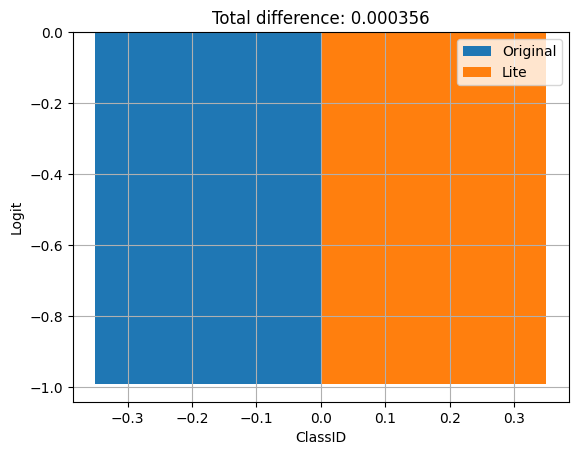

In [ ]:
#@title
def compare_logits(logits):
  width = 0.35
  offset = width/2
  assert len(logits)==2

  keys = list(logits.keys())
  print(np.arange(len(logits[keys[0]]) - offset))
  plt.bar(x = np.arange(len(logits[keys[0]]))-offset,
      height=logits[keys[0]], width=0.35, label=keys[0])
  plt.bar(x = np.arange(len(logits[keys[1]]))+offset,
      height=logits[keys[1]], width=0.35, label=keys[1])
  plt.legend()
  plt.grid(True)
  plt.ylabel('Logit')
  plt.xlabel('ClassID')

  delta = np.sum(np.abs(logits[keys[0]] - logits[keys[1]]))
  plt.title(f"Total difference: {delta:.3g}")

compare_logits({'Original': logits_original, 'Lite': logits_lite})

In [ ]:
import os

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

model_file_path = os.path.join('model.tflite')
with open(model_file_path, 'wb') as model_file:
  model_file.write(tflite_model)